In [ ]:
!pip install gdown
!pip install gensim

In [ ]:
!gdown https://drive.google.com/uc?id=1NNpbV5N9MDj4vn-k5ANT1nqY9-z_vGRa
!gdown https://drive.google.com/uc?id=18iBU4VFLg8zCrh5iZ66mbLJ51iJaWs4Z
#Get pretrained word2vec vectors - this file size is around 350 MB
!gdown https://drive.google.com/uc?id=1r0A1UNRIlZy9QgTU_aMDgpw1FcI8HnDE

Downloading...
From: https://drive.google.com/uc?id=1NNpbV5N9MDj4vn-k5ANT1nqY9-z_vGRa
To: /content/test.csv
100% 331k/331k [00:00<00:00, 48.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=18iBU4VFLg8zCrh5iZ66mbLJ51iJaWs4Z
To: /content/train.csv
100% 974k/974k [00:00<00:00, 64.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r0A1UNRIlZy9QgTU_aMDgpw1FcI8HnDE
To: /content/turkish_word2vec_300D
337MB [00:02, 122MB/s]


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#some libraries cause this future warnings when the newer versions will be released. To prevent showing them, this code is used.

# WORD2VEC OVERVIEW

In [ ]:
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format(r"/content/turkish_word2vec_300D" , binary=True)

All word vectors are 300 dimensional dense vectors. 

In [ ]:
word2vec["gözlük"].shape

(300,)

Thanks to these dense vectors, semantic and syntactic similarities can be captured between the words because the similar word vectors are closer to each other in the 300-d vector space compared to different words

In [ ]:
word2vec.most_similar("kalem",topn=3) #top 3 similar word for cat: as seen, kalemi (syntactic similarity) and mürekkepli & hokka (semantic similarity)

[('kalemi', 0.5952301025390625),
 ('mürekkepli', 0.558534562587738),
 ('hokka', 0.5307831764221191)]

In [ ]:
word2vec.most_similar("hollanda",topn=3)

[('belçika', 0.8035739660263062),
 ('danimarka', 0.7894425392150879),
 ('almanya', 0.710444450378418)]

By utilizing this relationships, it is possible to create both syntactic and semantic analogies.

In [ ]:
def analogy(x1, x2, y1):
    result = word2vec.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
#semantic analogies
analogy('kral', 'erkek', 'kraliçe')

'kadın'

In [ ]:
#syntactic analogies
analogy('uzun', 'uzunluk', 'kalın')

'kalınlık'

Let's see the words and their positions in the 2-dimensional vector space by using dimension reduction techniques (PCA)!

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def display_pca_scatterplot(model, words):
       
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()


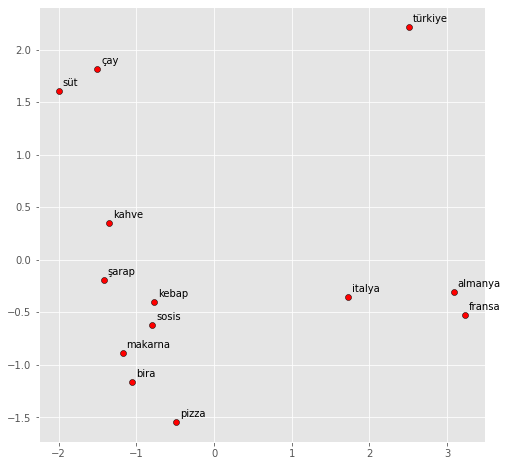

In [ ]:
words=['kahve', 'çay', 'bira', 'şarap', 'süt',
      'makarna', 'sosis', 'pizza', 'kebap', 
      'fransa', 'italya', 'almanya', 'türkiye']
display_pca_scatterplot(word2vec,words)

#  kitapyurdu.com - REVIEWS AND RATINGS DATASET

Original kitapyurdu.com dataset contains around 125K reviews and ratings. However, training the model with this amount takes a lot of time. Therefore, we previously prepare the data as highly balanced and smaller size. The reason for that **handling imbalanced data is advanced topic, if you are interestedn in this, [you can follow this paper.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907)** The script includes data preparation steps will be shared with participants after the workshop.

In [ ]:
import pandas as pd
df_train = pd.read_csv(r"train.csv",index_col=[0])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print()
print(df_train["label"].value_counts())
df_test = pd.read_csv(r"test.csv",index_col=[0])
# Report the number of sentences.
print()
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
print()
print(df_test["label"].value_counts())

Number of training sentences: 7,050


2    2350
1    2350
0    2350
Name: label, dtype: int64

Number of test sentences: 2,400


1    800
2    800
0    800
Name: label, dtype: int64


**Classes:**



0.   Negative
1.   Neutral
2.   Positive


In [ ]:
df_train.head()

,review,label
0,Kitabı bugün 3. defa kaldığım yerden devam etm...,0
1,Stefan zweig’in en sevdiğim özelliği basit cüm...,0
2,Her yerde karşıma çıktığı için almıştım .Norma...,0
3,kitapların damağımızda bıraktığı tadı paylaşab...,0
4,Çocukken okumuş ve feci sıkılarak yarım bırakm...,0


In [ ]:
df_test.head()

,review,label
0,Şunu söylemekte fayda görüyorum yazar ile bizi...,0
1,çok sarmadı beni bitirmek için seriyi başladım...,0
2,köşe yazısı gibi zaman israfı keşke bir kez da...,0
3,Kişiler cok oldugu için kafanı karıştırıyor ak...,0
4,BEKLENTİMİ KARŞILAYAN BİR KİTAP OLMADI..,0


## TEXT PREPROCESSING

In [ ]:
 df_train.review[0]

'Kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. Ancak yine daha iyi anlamak için baştan başladım(3. defa). Hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. Hadi bakalım inşallah bu sefer bitireceğim kitabı. Son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.'

In [ ]:
import numpy as np 
import nltk
import string as s
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocess(text,remove_stop_punc=False):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
 
  #remove punctuations and stop words
  stop_words=stopwords.words('turkish')
  tokens=nltk.word_tokenize(text)
  if remove_stop_punc:
    tokens_new=[i for i in tokens if not i in stop_words and i.isalpha()] #isalpha() method returns True if all the characters are alphabet letters
  else:
    tokens_new=tokens
  

  #remove excess whitespace
  text= ' '.join(tokens_new)
  return text

df_train["review"]=df_train["review"].apply(preprocess,remove_stop_punc=True)
df_test["review"]=df_test["review"].apply(preprocess,remove_stop_punc=True)

#Remove reviews which have no word in them
df_train["Text_length"] = [len(text.split(' ')) for text in df_train.review]
df_train = df_train[df_train["Text_length"]>1]

#Remove reviews which have no word in them
df_test["Text_length"] = [len(text.split(' ')) for text in df_test.review]
df_test = df_test[df_test["Text_length"]>1]


In [ ]:
df_train.review[0]

'kitabı bugün kaldığım yerden devam etmek elime aldım ancak yine iyi anlamak baştan başladım hatta kararsızım okuyup okumamakta bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni hadi bakalım inşallah sefer bitireceğim kitabı son yapılan yoruma istinaden umarım sayfadan sonra ben aynı düşüncelere sahip olurum'

##### **BEFORE PREPROCESSING:**

>  Kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. Ancak yine daha iyi anlamak için baştan başladım(3. defa). Hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. Hadi bakalım inşallah bu sefer bitireceğim kitabı. Son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.


# FEATURE EXTRACTION WITH WORD2VEC

To obtain sentence or news vector representations, the aggregation of word vectors is required. There are lots of approaches in the applications. In this workshop, we will take average of word vectors to represent news. 

Also, in the related function, we add if condition which controls whether the related word exists in vocabular or not because Word2vec may not have all possible word vectors. Therefore, out-of-vocabulary (OOV) problem can occur if words do not exist.

In [ ]:
def vocab_control(word):
  if word in word2vec.vocab.keys():
    print("{} exists in the vocabulary".format(word))
  else:
    print("{} does not exist in the vocabulary and it is the example for OOV problem".format(word))

In [ ]:
vocab_control("isveç")

isveç exists in the vocabulary


In [ ]:
vocab_control("avusturalya") #typo exists on purpose

avusturalya does not exist in the vocabulary and it is the example for OOV problem


In [ ]:
from nltk.tokenize import WordPunctTokenizer
WPT = WordPunctTokenizer()

def news_embed(sentence):
    sentence=sentence.lower()
    tokens=WPT.tokenize(sentence)
    new_tokens=[token for token in tokens]

    sent_list=[]
    for word in new_tokens:
        if word in word2vec.vocab.keys():
          wv=word2vec[word]
          sent_list.append(wv)
        else:
          continue
    if len(sent_list)<1:
      dummy=np.random.normal(0.5, 0.25, 300)
      sent_list.append(dummy)
    sent_embed= np.mean(sent_list,axis=0)
    return sent_embed

In [ ]:
sentence="Principai özelleştirilmiş NLP çözümleri sunan bir şirkettir."

In [ ]:
a=news_embed(sentence)
a.shape

(300,)

In [ ]:
type(a)

numpy.ndarray

In [ ]:
texts = df_train.review
labels = df_train.label

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels, random_state=42, test_size=0.2)

test_x=df_test.review
test_y=df_test.label

In [ ]:
train_array=np.array([news_embed(news) for news in train_x])
valid_array=np.array([news_embed(news) for news in valid_x])
test_array=np.array([news_embed(news) for news in test_x])
train_array.shape

(5625, 300)

# MODELLING

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). However, **it requires non-negative inputs.** Since w2v vectors may have negative values, we will apply Linear Support Vector Classifier algorith via [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) library.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0,max_iter=2000)
model.fit(train_array, train_y)
pred=model.predict(valid_array)
from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of W2V and LinearSVC over validation set is:",accuracy_score(valid_y, pred))

print(classification_report(valid_y, pred))


Accuracy of W2V and LinearSVC over validation set is: 0.5181236673773987
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       490
           1       0.45      0.39      0.42       472
           2       0.55      0.65      0.60       445

    accuracy                           0.52      1407
   macro avg       0.51      0.52      0.51      1407
weighted avg       0.51      0.52      0.51      1407



#TESTING THE MODEL

In [ ]:
test_pred=model.predict(test_array)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of W2V and LinearSVC over test set is:",accuracy_score(test_y, test_pred))

print(classification_report(test_y, test_pred))


Accuracy of W2V and LinearSVC over test set is: 0.5419624217118998
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       799
           1       0.47      0.41      0.44       798
           2       0.60      0.67      0.63       798

    accuracy                           0.54      2395
   macro avg       0.54      0.54      0.54      2395
weighted avg       0.54      0.54      0.54      2395



<Figure size 432x288 with 0 Axes>

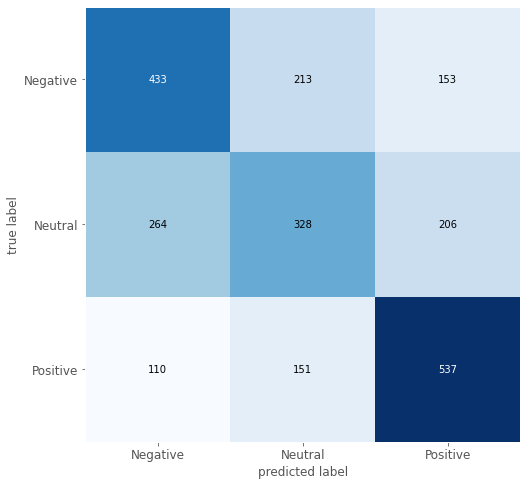

In [ ]:
cm  = confusion_matrix(test_y, test_pred)
labels = ['Negative', 'Neutral', 'Positive']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), labels, fontsize=12)
plt.yticks(range(3), labels, fontsize=12)
plt.show()